In [67]:
import gym
import gym.spaces
import numpy as np
from qiskit.circuit.library import *
from scipy.interpolate import interp1d
from qiskit.quantum_info import average_gate_fidelity
from stable_baselines3.common.policies import ActorCriticPolicy, ActorCriticCnnPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.ppo import PPO
from stable_baselines3.a2c import A2C
from stable_baselines3.common.utils import set_random_seed
from qiskit.quantum_info import Operator
from qiskit.circuit import QuantumCircuit

In [2]:
def apply_single_qubit_gate(qubits, gate, i):
    out_gate = 1
    # apply the single qubit gate to the ith qubit
    for j in range(qubits):
        if j == i:
            out_gate = np.kron(out_gate, gate.to_matrix())
        else:
            out_gate = np.kron(out_gate, IGate().to_matrix())

    return out_gate

In [3]:
apply_single_qubit_gate(2, XGate(), 1)

array([[0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

In [4]:
gate = apply_single_qubit_gate(3, HGate(), 1)
print(gate.shape)

(8, 8)


In [5]:
def apply_cnot_gate(qubits, i, j):
    out_1, out_2 = 1, 1
    # apply the cnot gate between the ith and jth qubits
    # ith qubit is the control qubit and jth qubit is the target qubit
    for k in range(qubits):
        if k == i:
            out_1 = np.kron(out_1, np.array([[1, 0], [0, 0]]))
            out_2 = np.kron(out_2, np.array([[0, 0], [0, 1]]))
        elif k == j:
            out_1 = np.kron(out_1, IGate().to_matrix())
            out_2 = np.kron(out_2, XGate().to_matrix())
        else:
            out_1 = np.kron(out_1, IGate().to_matrix())
            out_2 = np.kron(out_2, IGate().to_matrix())

    return out_1 + out_2

In [6]:
cnot_gate = apply_cnot_gate(2, 0, 1)
print(gate.shape)

(8, 8)


In [7]:
cnot_gate @ [0, 0, 0, 1] == [0, 0, 1, 0]

array([ True,  True,  True,  True])

In [8]:
print(CXGate().name)

cx


In [9]:
print(PhaseGate(np.pi / 4).name)

p


In [10]:
angles = np.linspace(0.0, 2 * np.pi, 8)
# RX_GATES = [RXGate(theta) for theta in angles]
# RY_GATES = [RYGate(theta) for theta in angles]
PHASE_GATES = [PhaseGate(np.pi * 2 * r / 8, label=f"p(pi/{r})") for r in range(8)]
SINGLE_GATES = [
    HGate(),
    TGate(),
    TdgGate(),
]
TWO_QUBIT_GATES = [CXGate()]

In [99]:
class GateSynthesisEnv(gym.Env):
    def __init__(self, actions, goal, gamma=0.9, max_steps=25):
        self.interp = interp1d([-1.001, 1.001], [0, 2**5])
        # goal is a matrix representation of the gate, its size decides the number of qubits
        self.goal = goal
        # discount factor
        self.gamma = gamma
        # identify the observation and action spaces
        # a state is (2^n) x (2^n) x 2
        # dim 2 for real and image parts of the complex numbers
        self.observation_space = gym.spaces.Box(
            low=0, high=2**5, shape=(*goal.shape, 2), dtype=float
        )
        self._actions = actions
        self.action_space = gym.spaces.Discrete(len(actions))
        self._states = np.identity(goal.shape[0], dtype=complex)
        # print("init states", self._states)
        self.state = self.interp(
            np.stack([self._states.real, self._states.imag], axis=-1)
        )
        self.program = []
        self.current_step = 0
        self.max_steps = max_steps
        self.info = {}

    def step(self, action):
        gate = self._actions[action]
        # print(gate)
        # print(gate["matrix"].shape)
        # print("before gate", self._states.shape)
        self._states = gate["matrix"] @ self._states
        self.state = self.interp(
            np.stack([self._states.real, self._states.imag], axis=-1)
        )
        # print("interpolated states", self.state)
        self.program.append(gate)
        self.current_step += 1
        # print("reward", states.T.conj() * self.goal_states)

        reward = average_gate_fidelity(
            Operator(self._states), target=Operator(self.goal)
        )
        if reward > 0.98:
            done = True
            reward = 1
        elif self.current_step >= self.max_steps:
            done = True
        else:
            done = False
            reward = 0

        return self.state, reward, done, self.info

    def reset(self):
        self.program = []
        states = np.identity(self.goal.shape[0])
        self.state = self.interp(np.stack([states.real, states.imag], axis=-1))
        self.current_step = 0
        self._states = states

        return self.state

In [106]:
set_random_seed(14)


class MultiGateSynthesizer:
    def __init__(self, circuit, lr=3e-4, model="ppo"):
        self.qubits = circuit.num_qubits
        gates = [
            {
                "name": "I",
                "matrix": np.identity(2**self.qubits),
            }
        ]
        for gate in SINGLE_GATES:
            for i in range(self.qubits):
                gates.append(
                    {
                        "name": f"{gate.name if gate.label is None else gate.label}({i})",
                        "matrix": apply_single_qubit_gate(self.qubits, gate, i),
                    }
                )
        for i in range(self.qubits):
            for j in range(self.qubits):
                if i != j:
                    gates.append(
                        {
                            "name": f"cnot({i},{j})",
                            "matrix": apply_cnot_gate(self.qubits, i, j),
                        }
                    )

        self.env = GateSynthesisEnv(gates, Operator(circuit).data)

        if model == "ppo":
            self.model = PPO(
                ActorCriticPolicy,
                self.env,
                learning_rate=lr,
                ent_coef=1e-5,
                verbose=1,
                tensorboard_log="./circuit_rl_tensorboard/",
            )
        else:
            self.model = A2C(ActorCriticPolicy, self.env, verbose=1)

    def solve(self, max_steps):
        self.model.learn(total_timesteps=max_steps)

    def check(self):
        done = False
        obs = self.env.reset()
        program = []

        while not done:
            optimal_action, _ = self.model.predict(obs)
            program.append(self.env._actions[optimal_action])
            obs, rewards, done, info = self.env.step(optimal_action)

        print("Found synthesis result:")
        for ac in program:
            print(ac["name"])

        return program

In [107]:
def check_result(program, target_circuit):
    gate = program[0]["matrix"]
    for ac in program[1:]:
        gate = ac["matrix"] @ gate

    goal_gate = Operator(target_circuit).data
    assert np.allclose(gate, goal_gate)

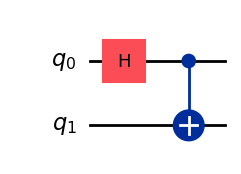

In [97]:
# Bell state
target_circuit = QuantumCircuit(2)
target_circuit.h(0)
target_circuit.cx(0, 1)
target_circuit.draw("mpl")

In [98]:
synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(60000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_186


/home/zheng/anaconda3/envs/circuit_rl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 0.293    |
| time/              |          |
|    fps             | 1715     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 0.228       |
| time/                   |             |
|    fps                  | 1375        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008854543 |
|    clip_fraction        | 0.0907      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.19       |
|    explained_variance   | -3.48       |
|    learning_rate        | 0.

In [38]:
check_result(program, target_circuit)

In [71]:
# swap gate
target_circuit = QuantumCircuit(2)
target_circuit.swap(0, 1)
target_circuit.draw()

q_0: ─X─
      │ 
q_1: ─X─

In [72]:
synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(60000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_177


/home/zheng/anaconda3/envs/circuit_rl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 0.251    |
| time/              |          |
|    fps             | 1726     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 20         |
|    ep_rew_mean          | 0.257      |
| time/                   |            |
|    fps                  | 1387       |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01881197 |
|    clip_fraction        | 0.16       |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.19      |
|    explained_variance   | -4.77      |
|    learning_rate        | 0.000966   |
|   

In [41]:
check_result(program, target_circuit)

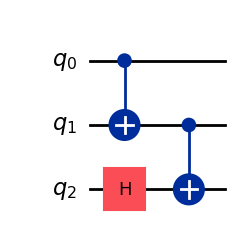

In [42]:
# Random 3-qubit gate with three steps
target_circuit = QuantumCircuit(3)
target_circuit.cx(0, 1)
target_circuit.h(2)
target_circuit.cx(1, 2)
target_circuit.draw("mpl")

In [43]:
set_random_seed(111)
synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(60000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_169
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 0.119    |
| time/              |          |
|    fps             | 1669     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 0.126       |
| time/                   |             |
|    fps                  | 1340        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009431006 |
|    clip_fraction        | 0.0836      |
|    clip_range   

In [44]:
check_result(program, target_circuit)

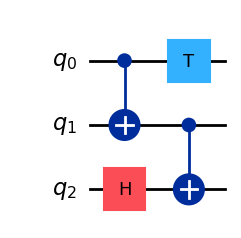

In [45]:
# Random 3-qubit gate with three steps
target_circuit = QuantumCircuit(3)
target_circuit.cx(0, 1)
target_circuit.h(2)
target_circuit.cx(1, 2)
target_circuit.t(0)
target_circuit.draw("mpl")

In [48]:
set_random_seed(111)
synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(100000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_171
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 0.122    |
| time/              |          |
|    fps             | 1674     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 0.131       |
| time/                   |             |
|    fps                  | 1343        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008313979 |
|    clip_fraction        | 0.0816      |
|    clip_range   

In [49]:
check_result(program, target_circuit)

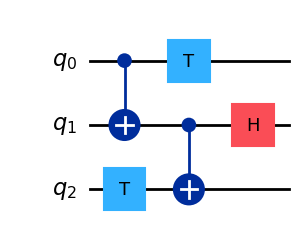

In [108]:
# Random 3-qubit gate
target_circuit = QuantumCircuit(3)
target_circuit.cx(0, 1)
target_circuit.t(2)
target_circuit.cx(1, 2)
target_circuit.t(0)
target_circuit.h(1)
target_circuit.draw("mpl")

In [110]:
set_random_seed(111)
synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(250000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_190


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 0.123    |
| time/              |          |
|    fps             | 1644     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25          |
|    ep_rew_mean          | 0.121       |
| time/                   |             |
|    fps                  | 1339        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008265775 |
|    clip_fraction        | 0.0535      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    explained_variance   | -1.99       |
|    learning_rate        | 0.

In [111]:
check_result(program, target_circuit)

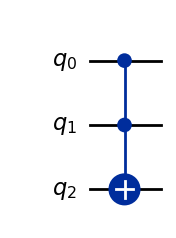

In [112]:
# Toffli gate
target_circuit = QuantumCircuit(3)
target_circuit.ccx(0, 1, 2)
target_circuit.draw("mpl")

In [113]:
def linear_schedule(initial_value):
    """
    Linear learning rate schedule.
    :param initial_value: (float or str)
    :return: (function)
    """
    if isinstance(initial_value, str):
        initial_value = float(initial_value)

    def func(progress):
        """
        Progress will decrease from 1 (beginning) to 0
        :param progress: (float)
        :return: (float)
        """
        return progress * initial_value

    return func


synthesizer = MultiGateSynthesizer(target_circuit, lr=1e-4)
synthesizer.solve(3000000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_191


/home/zheng/anaconda3/envs/circuit_rl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 0.123    |
| time/              |          |
|    fps             | 1687     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 25         |
|    ep_rew_mean          | 0.127      |
| time/                   |            |
|    fps                  | 1348       |
|    iterations           | 2          |
|    time_elapsed         | 3          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00536507 |
|    clip_fraction        | 0.0125     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.77      |
|    explained_variance   | -8.92      |
|    learning_rate        | 0.0001     |
|   

KeyboardInterrupt: 